In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from scipy.fft import rfft, rfftfreq
import numpy as np

def logit_normalise(df, cols, order=1):
    for c in cols:
        df[c + "[pu]"] = df[c] / (df[c].max() + 0.001)
        df[c + "-LNT"] = np.log(df[c + "[pu]"]**order /
                                (1 - df[c + "[pu]"]**order))
    return df

def make_rfft(data, sample_rate=500.5005):
    yf = rfft(data)
    xf = rfftfreq(len(data), 1 / sample_rate)
    return xf, np.abs(yf)

# NREL data

In [1]:
df_power = pd.read_csv("datasets/wtk_power.csv", parse_dates=True, infer_datetime_format=True)
df_wind = pd.read_csv("datasets/wtk_wind.csv", parse_dates=True, infer_datetime_format=True)
df_power["datetime"] = pd.date_range(start="2012-07-01 00:00:00", end="2013-01-01 00:00:00", freq="5min")
df_wind["datetime"] = pd.date_range(start="2012-07-01 00:00:00", end="2013-01-01 00:00:00", freq="5min")
df_power = df_power.set_index("datetime")
df_power[df_power<=0] = 0.001
df_wind = df_wind.set_index("datetime")
site_ids = df_power.columns.tolist()
df_power.describe()

NameError: name 'pd' is not defined

In [ ]:
fig, axs = plt.subplots()
# axs = axs.flatten()
df_power = logit_normalise(df_power, cols = df_power.columns)
for i in range(1):
    # axs[i].hist(df_power[site_ids[i]+"-LNT"], bins="auto")
    # df_power.drop(columns=[site_ids[i]], inplace=True)
    # axs[i].plot(df_wind.iloc[:,i])
    axs.plot(df_power.iloc[:3000,i])
    # axs[i].scatter(df_wind.iloc[:,i], df_power.iloc[:,i])
fig.tight_layout()

In [ ]:
df_power = pd.read_csv("datasets/wtk_power.csv",
                           parse_dates=True,
                           infer_datetime_format=True,
                           index_col=0).values
print(df_power)
# df_power = df_power[:24*12*2]
N = len(df_power)
SAMPLE_RATE = 1/300 * 2 * np.pi
fig, axs = plt.subplots(4,5,figsize=[5*5, 4*4])
axs = axs.flatten()
for i in range(20):
    yf = rfft(df_power[:,i].flatten())
    xf = rfftfreq(N, 1/SAMPLE_RATE)
    axs[i].plot(xf, yf)
fig.tight_layout()


In [ ]:
df_power.describe()
df_power.to_csv("datasets/NREL_power.csv")

/tmp/ipykernel_4041087/2337742381.py:6: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_wind = pd.read_csv("datasets/wtk_wind.csv",
/tmp/ipykernel_4041087/2337742381.py:10: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_power = pd.read_csv("datasets/NREL_power.csv",


(576, 2)


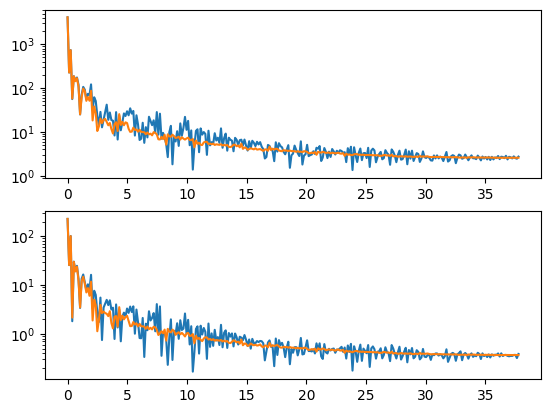

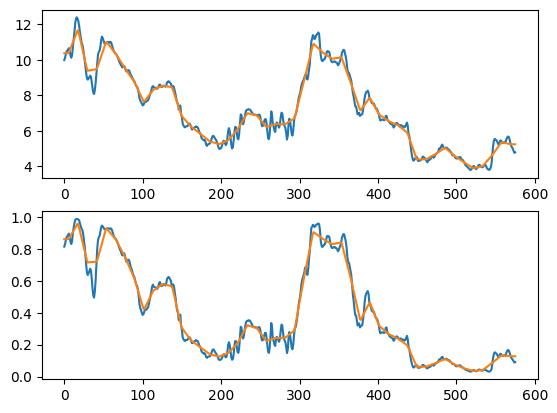

In [4]:
import torch


avg_kernal_size = 12
choose = 9
df_wind = pd.read_csv("datasets/wtk_wind.csv",
                          parse_dates=True,
                          infer_datetime_format=True,
                          index_col=0)
df_power = pd.read_csv("datasets/NREL_power.csv",
                        parse_dates=True,
                        infer_datetime_format=True,
                        index_col=0)
select_site = df_wind.columns[choose]
df_wind_select = df_wind[select_site].values
df_power_select = df_power[select_site + "[pu]"].values

start = 2000
end = start + 24*2*12
df = np.concatenate([df_wind_select.reshape(-1,1), df_power_select.reshape(-1,1)], axis=1)[start:end]
print(df.shape)
t = np.arange(len(df))/12
SAMPLE_RATE= len(df)/(t.max()-t.min()) * 2*np.pi


wind_speed = df[:,0]
wind_speed_avg = torch.nn.AvgPool1d(avg_kernal_size,avg_kernal_size)(torch.from_numpy(wind_speed).reshape(1,1,-1))
# print(y_avg.shape)
wind_speed_interp_ai = torch.nn.functional.interpolate(wind_speed_avg, size=len(df), mode="linear").numpy().flatten()


wind_power = df[:,1]
wind_power_avg = torch.nn.AvgPool1d(avg_kernal_size,avg_kernal_size)(torch.from_numpy(wind_power).reshape(1,1,-1))
# print(y_avg.shape)
wind_power_interp_ai = torch.nn.functional.interpolate(wind_power_avg, size=len(df), mode="linear").numpy().flatten()

yf_ws = rfft(wind_speed)
xf_ws = rfftfreq(len(wind_speed), 1/SAMPLE_RATE)
yf_wp = rfft(wind_power)
xf_wp = rfftfreq(len(wind_power), 1/SAMPLE_RATE)

yf_ws_interp = rfft(wind_speed_interp_ai)
xf_ws_interp = rfftfreq(len(wind_speed_interp_ai), 1/SAMPLE_RATE)
yf_wp_interp = rfft(wind_power_interp_ai)
xf_wp_interp = rfftfreq(len(wind_power_interp_ai), 1/SAMPLE_RATE)

fig, axs=plt.subplots(2)
axs[0].plot(xf_ws, np.abs(yf_ws))
axs[0].plot(xf_ws_interp, np.abs(yf_ws_interp))
axs[0].set_yscale('log')
axs[1].plot(xf_wp, np.abs(yf_wp))
axs[1].plot(xf_wp_interp, np.abs(yf_wp_interp))
axs[1].set_yscale('log')

fig, axs=plt.subplots(2)
axs[0].plot(wind_speed)
axs[0].plot(wind_speed_interp_ai)
# axs[0].set_yscale('log')
axs[1].plot(wind_power)
axs[1].plot(wind_power_interp_ai)
# axs[1].set_yscale('log')


                         5min     15min     60min
ds                                               
2019-01-01 05:00:00  0.283403  0.284878  0.263034
2019-01-01 05:05:00  0.289713  0.278004  0.260037
2019-01-01 05:10:00  0.281517  0.271131  0.257039
2019-01-01 05:15:00  0.263150  0.264258  0.254041
2019-01-01 05:20:00  0.266563  0.259676  0.251044
...                       ...       ...       ...
2019-01-02 23:35:00  0.410300  0.414784       NaN
2019-01-02 23:40:00  0.407650  0.420249       NaN
2019-01-02 23:45:00  0.414833  0.425714       NaN
2019-01-02 23:50:00  0.429363       NaN       NaN
2019-01-02 23:55:00  0.432947       NaN       NaN

[516 rows x 3 columns]


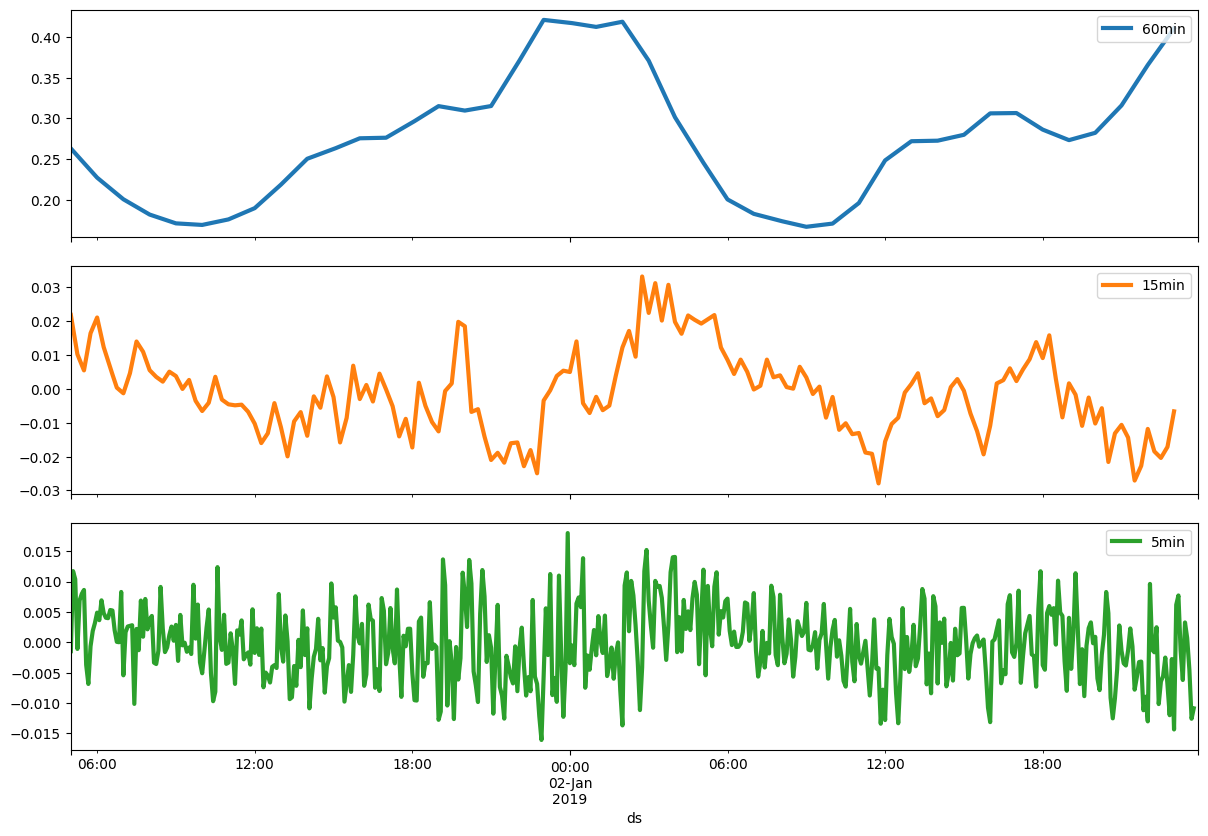

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("datasets/MFRED_wiztemp.csv",index_col=0, parse_dates=True)[["value"]]
# df = df.interpolate()
df = df["2019-01-01":"2019-01-02"]
fig, axs = plt.subplots(3, figsize=[12,8], sharex=True)
df_15min = df.resample("15min").mean()
df_15min = df_15min.resample("5min").mean().interpolate()
df_15min.columns=["15min"]
df_60min = df.resample("60min").mean()
df_60min = df_60min.resample("5min").mean().interpolate()
df_60min.columns=["60min"]
df.columns=["5min"]
df = pd.concat([df, df_15min,df_60min],axis=1)
print(df)
fig.tight_layout()

df["15res"] = df["15min"]-df["60min"]
df["5res"] = df["5min"]-df["15min"]
df.plot(y="5res", c="C2", label="5min", lw=3, ax=axs[2])
df.plot(y="15res", c="C1", label="15min", lw=3, ax=axs[1])
df.plot(y="60min",  c="C0", label="60min", lw=3, ax=axs[0])
for i in range(3):
    axs[i].legend(loc=1)

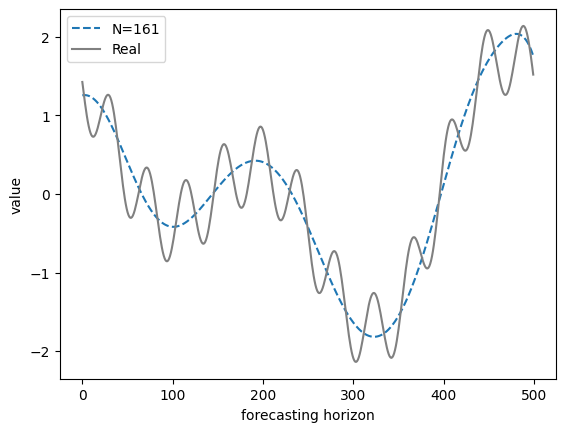

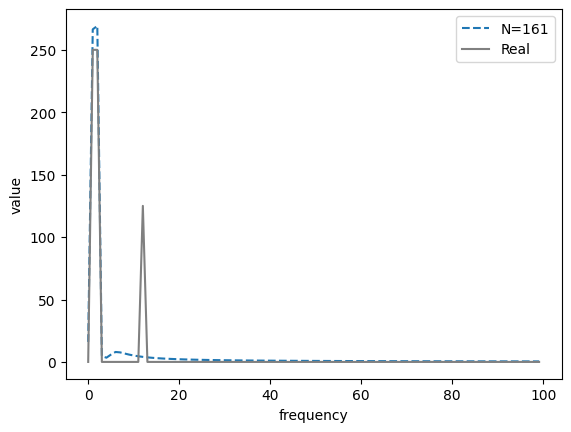

In [7]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pth = "results/sine/example_benchmarks-20230914-041044"
# pth = "results/sine/example_benchmarks-20230914-042542"

model_names = ['Neural Laplace']
fcst_features = [0]
all_seed_result = []
all_seed_preds = []
for seed in range(1):
    with open(f"{pth}-{seed}.pkl", "rb") as f:
        all_result = pickle.load(f)
    test_result = {name: {} for name in model_names}
    test_preds_trajs = {name: {} for name in model_names}
    for avg_terms in all_result:
        result_avg = all_result[avg_terms]
        train_mean = result_avg['train_mean'][fcst_features]
        train_std = result_avg['train_std'][fcst_features]
        num_avg_terms = int(avg_terms.split("_")[-1])
        for name in model_names:
            model_results = result_avg[name]
            assert len(fcst_features) == model_results["test_preds"].shape[-1]
            test_preds = model_results["test_preds"] * train_std.cpu().numpy(
            ) + train_mean.cpu().numpy()
            test_trajs = model_results["test_trajs"] * train_std.cpu().numpy(
            ) + train_mean.cpu().numpy()

            fig, ax=plt.subplots()
            ax.plot(test_preds[0].squeeze(), ls="--",label="N=161")
            ax.plot(test_trajs[0].squeeze(),label="Real",c="grey")
            ax.legend()
            ax.set_ylabel("value")
            ax.set_xlabel("forecasting horizon")
            # ax.set_title("Time domain")
            fig.savefig('savings/timesin_33.pdf')

            xf_test, yf_test = make_rfft(test_trajs[0].squeeze())
            xf_pred, yf_pred = make_rfft(test_preds[0].squeeze())
            fig, ax=plt.subplots()
            ax.plot(xf_pred[:100], yf_pred[:100],  ls="--",label="N=161")
            ax.plot(xf_test[:100], yf_test[:100],label="Real",c="grey")
            ax.legend()
            ax.set_ylabel("value")
            ax.set_xlabel("frequency")
            # ax.set_title("Frequency domain")
            fig.savefig('savings/freqsin_33.pdf')


            break
            pred_timesteps = test_trajs.shape[1]

            test_preds_trajs[name][num_avg_terms] = deepcopy(
                (test_preds, test_trajs))


